# Task 1: Pose Estimation

The function **estimate_pose** takes as input each instance of camera data and outputs the estimated position and euler angles of the quadrotor. The pose is obtained by solving the Perspective-n-Point (PnP) problem using the world and image points of detected corners of the april tags. If no tag ids are available in the camera data then empty arrays are returned by the function. A breif overview of my approach for camera pose estimation is given below:

**1. Loading and Extracting Necessary Data:**

Firstly, I load the data from a provided .mat file to extract camera sensor data - april tag ids, corner points in image frame and ground truth data - position, Euler angles, and timestamps.

**2. Image and World Point Calculation:**

Then, I calculate the world coordinates of the corner points of April tags based on their IDs using the **getWorldPoints** function. This involves using predefined map of tag IDs as shown below.

```python
# Map of april tag IDs 
tag_ids = np.array([[0, 12, 24, 36, 48, 60, 72, 84, 96],
                    [1, 13, 25, 37, 49, 61, 73, 85, 97],
                    [2, 14, 26, 38, 50, 62, 74, 86, 98],
                    [3, 15, 27, 39, 51, 63, 75, 87, 99],
                    [4, 16, 28, 40, 52, 64, 76, 88, 100],
                    [5, 17, 29, 41, 53, 65, 77, 89, 101],
                    [6, 18, 30, 42, 54, 66, 78, 90, 102],
                    [7, 19, 31, 43, 55, 67, 79, 91, 103],
                    [8, 20, 32, 44, 56, 68, 80, 92, 104],
                    [9, 21, 33, 45, 57, 69, 81, 93, 105],
                    [10, 22, 34, 46, 58, 70, 82, 94, 106],
                    [11, 23, 35, 47, 59, 71, 83, 95, 107]])
```

For a given tag id, I extract the row and column index of its position in the above map array. Based on the position in the array I calculate the world co-ordinates of the corner points of the tag.

It is given that - 'Each tag is a 0.152 m square with 0.152 m between tags, except for the space between columns 3 and 4, and 6 and 7, which is 0.178 m'. So the x and y co-cordinate for the corner p2 can be written as:

```python
p2x = 0.152*(2*row+1)
p2y = 0.152*(2*col+1) + (0.178 - 0.152)*(col//3)
```

The term (0.178 - 0152)*(col//3) takes care of the extra space between columns 3 and 4, and 6 and 7. After obtaining p2 corner co-ordinates, calculating the other corners is straightforward as shown below:

```python
p1x = p2x
p1y = p2y - 0.152

p3x = p1x - 0.152
p3y = p1y + 0.152

p4x = p1x - 0.152
p4y = p1y
```
The obtained corner points are packed into an array. The image co-ordinates for the corner points are obtained from the camera sensor data - p1,p2,p3,p4. I rearrange the corner points into a suitable format for OpenCV functions.

**3. Obtaining Camera Pose:**

I then obtain the camera pose by passing the image co-ordinates, world co-ordinates of corner points along with the given camera matrix and distortion parameters to the **cv2.solvePnP()** function.

$$ \text{camera\_matrix} = \begin{bmatrix}
314.1779 & 0 & 199.4848 \\
0 & 314.2218 & 113.7838 \\
0 & 0 & 1 \\
\end{bmatrix} $$

$$ \text{distortion\_params} = \begin{bmatrix}
-0.438607 & 0.248625 & 0.00072 & -0.000476 & -0.0911 \\
\end{bmatrix} $$

The solvePnP() function outputs a translation and rotation vector for the world frame w.r.t the camera frame.

**4. Transformation:**

After that, I transform the obtained camera pose into the robot/IMU frame pose w.r.t the world frame using the **cam2robotframe** function. The camera frame and robot/IMU frame are shown in the picture below. 

![Camera and robot frame configuration](/home/dheeraj/robot-navigation/NonlinearKalmanFilter/frames.png)

Based on the image above the transformation matrix of the robot/imu frame w.r.t the camera frame $T_{c}^{r}$ can be written as:

$$
T_{c}^{r} = \begin{pmatrix}
\cos\left(\frac{\pi}{4}\right) & -\cos\left(\frac{\pi}{4}\right) & 0 & -0.04 \\
-\sin\left(\frac{\pi}{4}\right) & -\sin\left(\frac{\pi}{4}\right) & 0 & 0.0 \\
0 & 0 & -1 & -0.03 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}
$$

Next I calculate the transformation matrix of the world frame w.r.t camera frame $T_{c}^{w}$ from the translation and rotation vectors obtianed by the solvePnP() function. The rotation matrix is obtained by passing the rotation vector to **cv2.rodriguez()** function.

The final transformation of the robot/imu frame w.r.t world frame is obtained by $$ T_{w}^{r} = T_{c}^{w^{-1}} \cdot T_{c}^{r} $$


I repeat this process for all camera data instances, generating position and orientation estimates along with corresponding timestamps.

**Challenges:** 

1. Empty April tag IDs: In some instances there are no april tags detected in the image and the tag id array is empty. Hence the camera pose cannot be estimated in such cases. So I set the position and euler angles as NaN whenever the pose cannot be estimated. 

# Task 2: Trajectory Visualization

Pose estimation is carried out for each given dataset and the results are plotted against the ground truth Vicon data. The **visualize_trajectory** function takes as input the dataset filename and plots the estimated poses against the ground truths. The function plots three figures, first is the 3D plot of the estimated position vs ground truth position, second figure consists of individual subplots of position co-ordinates (this was not required but it helps visualize how close the position estimates are to the ground truths) and the third figure is the subplots of the euler-angles.

Below are the trajectory visualization results for each dataset:

## Dataset 0

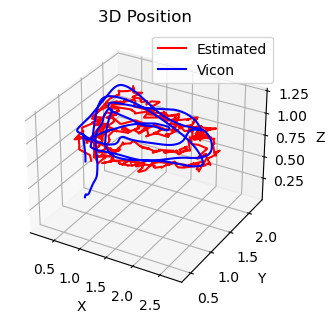

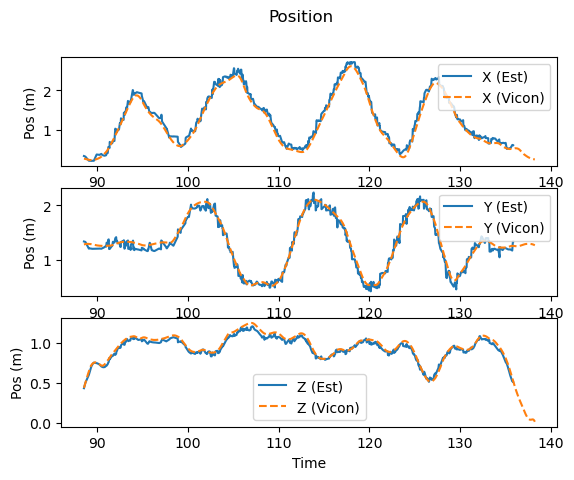

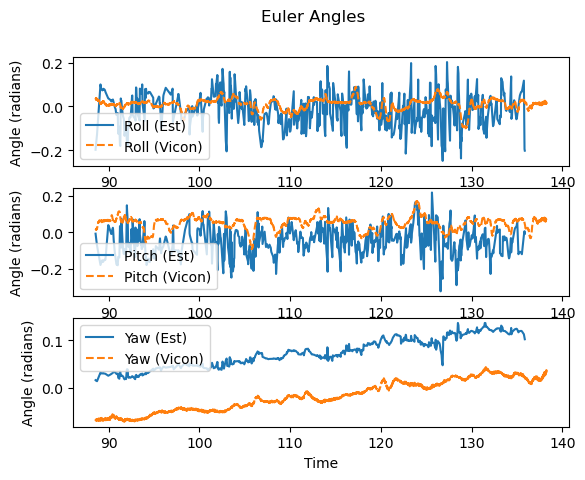

In [1]:
from pose_estimation import *

file_name = 'studentdata0.mat'
visualize_trajectory(file_name)

**Discussion:**

1. 3D Position: The estimated trajectory mirrors the Vicon reference closely, which demonstrates good estimation accuracy. There are some divergences along the path, but the overall shapes are similar.

2. Position: The estimated positions closely follow the Vicon data with high correlation, suggesting accurate estimation.

3. Euler Angles: The estimated measurements have slight deviations, indicating nosiy estimations, especially in roll and pitch. Also there is an noticeable offset in the yaw angle.

## Dataset 1

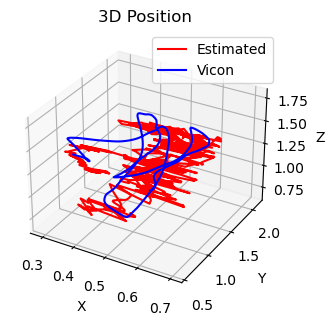

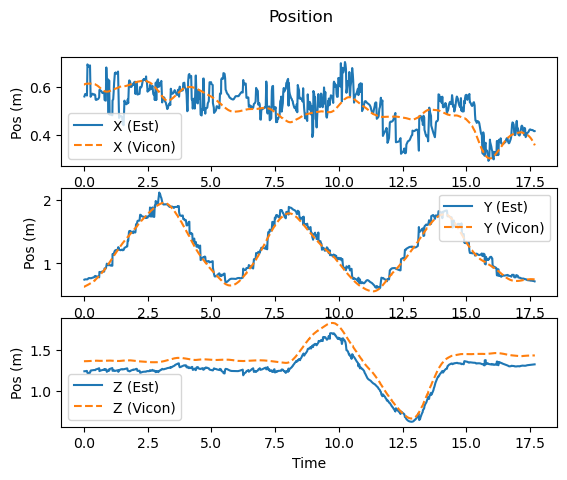

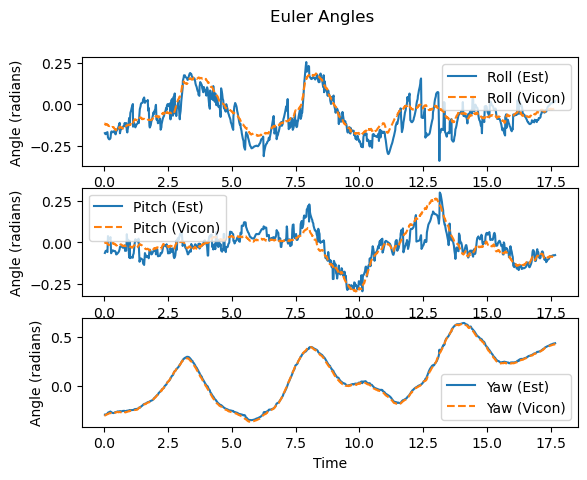

In [2]:
file_name = 'studentdata1.mat'
visualize_trajectory(file_name)


**Discussion:**
1. The 3D position plot reveals significant divergence between the estimated and reference trajectories, with the estimated path showing more variance and less smoothness.

2. In the position over time plot, the X and Y estimations have occasional deviations, while the Z estimation diverges more noticeably after around 12.5 units of time, indicating less reliable estimation in this axis.

3. The Euler Angles plot indicates a good estimation of yaw over time with minor divergence, while roll and pitch estimations show increased noise and deviation, suggesting less stability in these estimations.

## Dataset 2

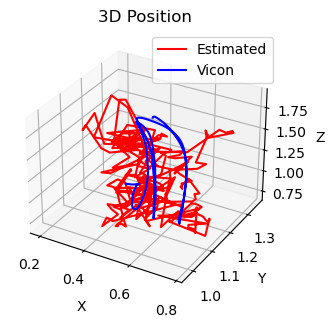

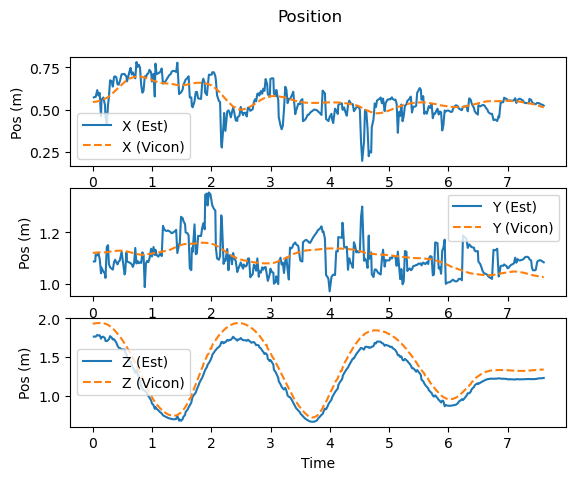

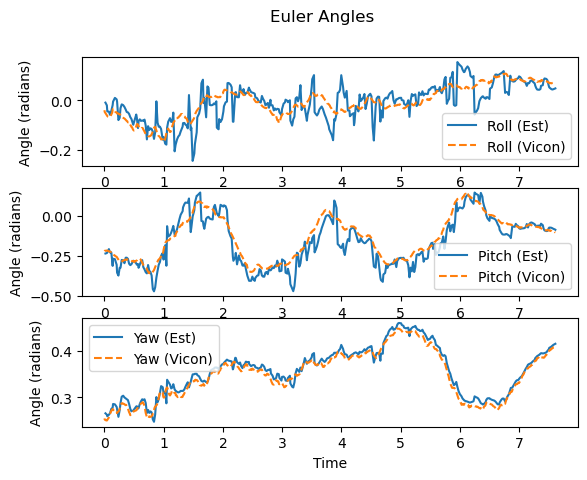

In [3]:
file_name = 'studentdata2.mat'
visualize_trajectory(file_name)

**Discussion:**

1. The estimated 3D position has large variances and often diverges significantly from the reference, suggesting a less accurate estimation process or errors in the estimation algorithm.

2. The X and Y position estimations show high-frequency fluctuations and short-term divergences from the reference, with X estimation showing greater deviation. The Z estimation, however, matches the reference with higher accuracy except for some peaks, demonstrating some consistency.

3. For the Euler angles, the roll estimation is particularly noisy, with pitch estimation showing some high peaks of deviation. The yaw estimation is the most accurate, with both estimations showing similar trends but with slight offsets and noise throughout.

## Dataset 3

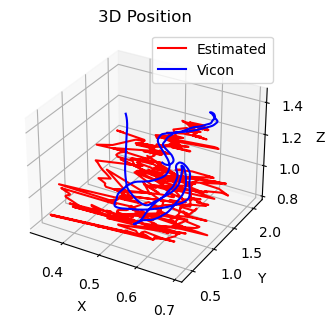

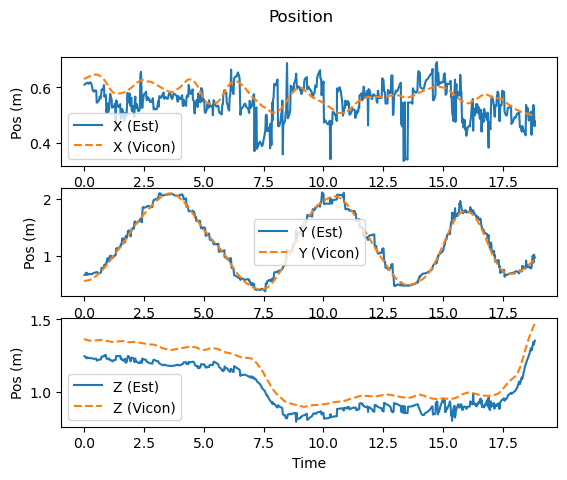

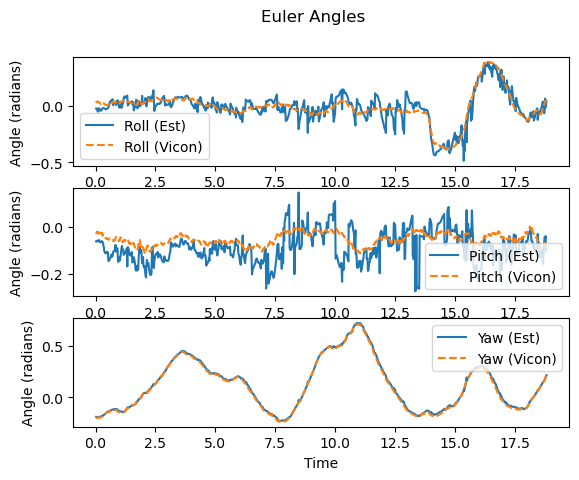

In [4]:
file_name = 'studentdata3.mat'
visualize_trajectory(file_name)

**Discussion:**
1. The 3D position comparison shows considerable discrepancies between the estimated and reference paths, with the estimated path being less smooth and more erratic.

2. For the position over time, the X estimation is quite erratic and shows many peaks diverging from the reference. The Y estimation, while following the same general pattern as the reference, exhibits several peaks and troughs. The Z estimation follows the reference but with a significant offset.

3. Regarding Euler angles, the pitch estimation is highly erratic with frequent deviations. The roll estimation, despite following the reference curve, has multiple instances of high deviation. The yaw estimation has a good correlation with the reference.

## Dataset 4

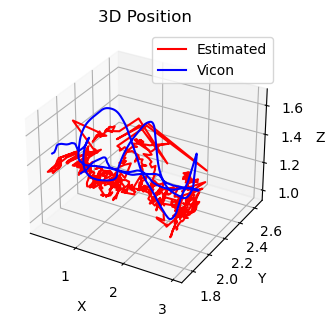

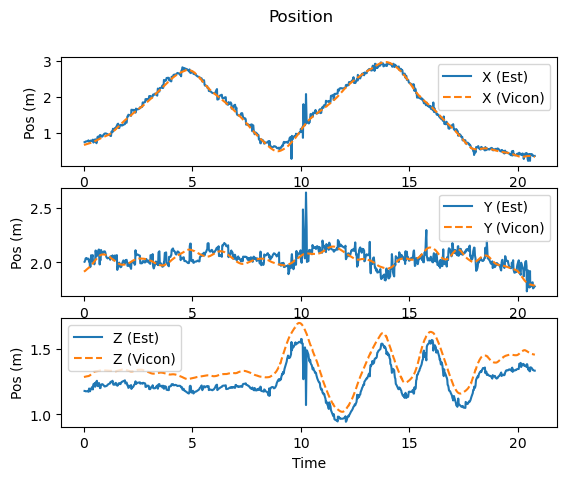

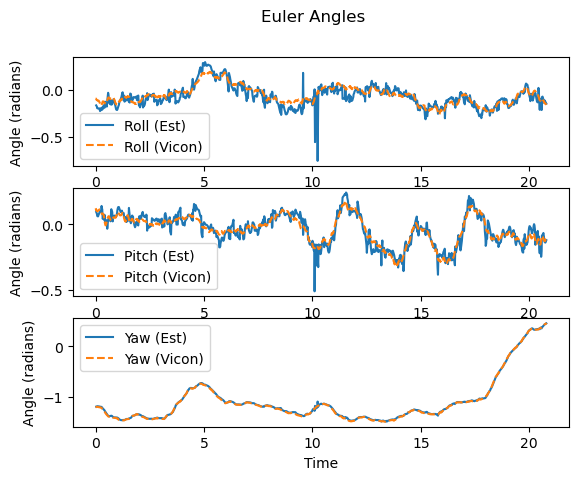

In [5]:
file_name = 'studentdata4.mat'
visualize_trajectory(file_name)

**Discussion:**

1. The estimated 3D position shows large discrepancies from the reference, with much greater variance and multiple loops diverging from the intended path.However the individual subplots show that the position do slightly follow the vicon groundtruths.

2. The X,Y and Z position estimates show some sporadic peaks that do not align with the reference around time=10s. The Z position estimation follows the reference but with a notable offset.

3. The roll and pitch estimations exhibit a high degree of noise with some sporadic peaks that do not align with the reference around time=10s similar tot he position subplots. The yaw estimation is closely aligned with the gorundtruths.

## Dataset 5

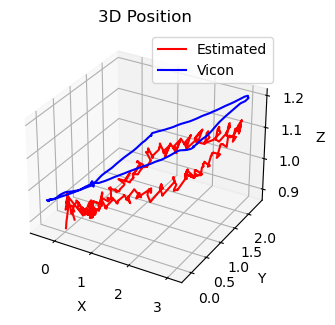

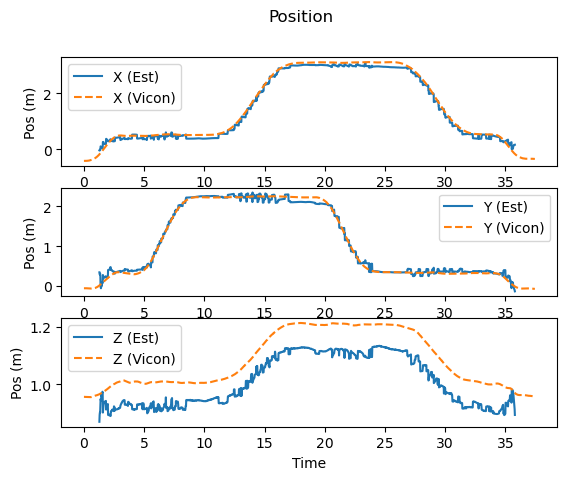

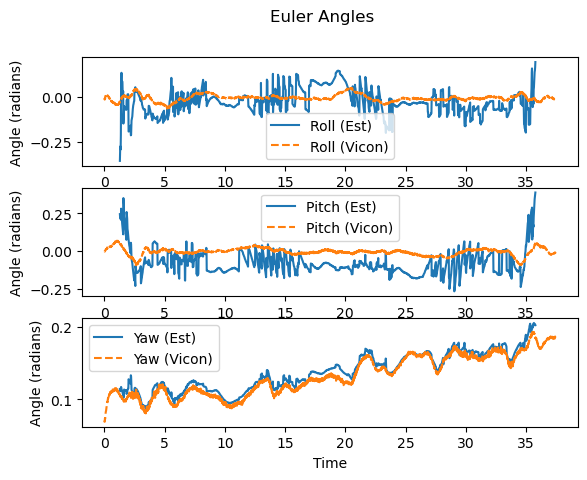

In [6]:
file_name = 'studentdata5.mat'
visualize_trajectory(file_name)

**Discussion:**

1. The 3D position comparison reveals a clear trend discrepancy with the estimated path significantly deviating from the reference, particularly in the Z dimension.

2. In the position plots, the X and Y estimation is mostly in agreement with the reference, whereas the Z estimations have a significant offset

3. For the Euler angles, roll and pitch estimations are quite noisy and show multiple spikes, while the yaw estimation shows a closer match to the reference gorundtruths but they still have deviations.

## Dataset 6

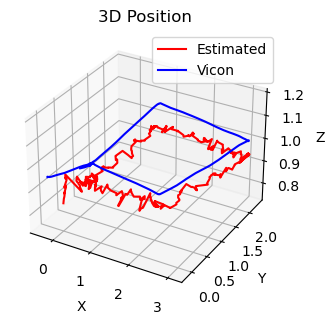

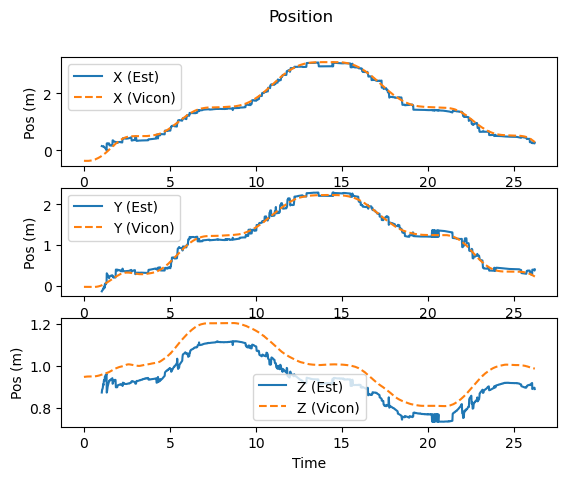

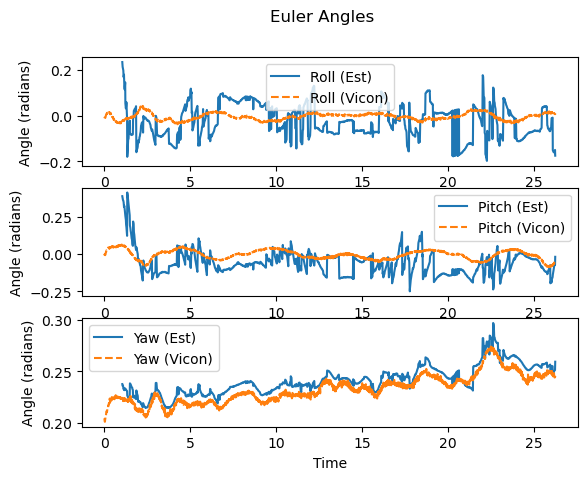

In [7]:
file_name = 'studentdata6.mat'
visualize_trajectory(file_name)

**Discussion:**

The results are quite similar to the previous dataset.

1. The 3D plot shows that there is a significant offset in the estimated trajectory in the Z dimension.

2. X and Y position estimates closely align with the reference. However there is an offset seen in Z postion estimates.

3. For Euler angles, roll and pitch esimtates show notable spikes with yaw estimation being better but still noisy.

## Dataset 7

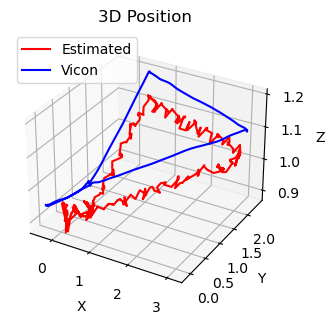

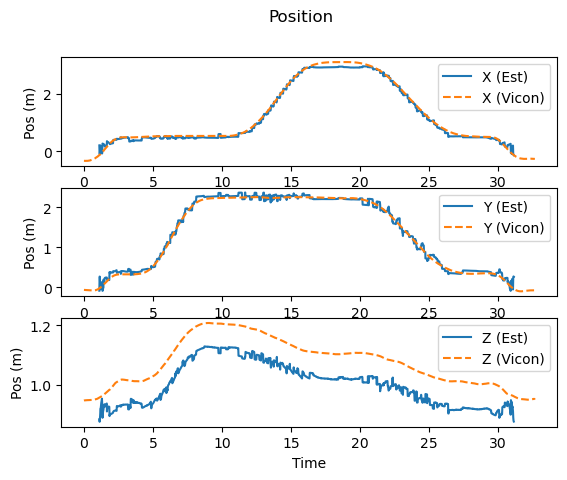

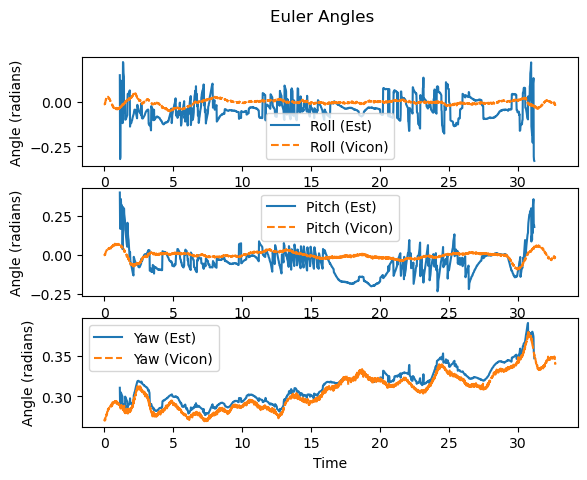

In [8]:
file_name = 'studentdata7.mat'
visualize_trajectory(file_name)

**Discussion:**

Results very similar to the two previous datasets. A significant offset is present in the Z position estimates. Roll and Pitch angle estimates have high frequency noise with yaw angle having less fluctuations but still off from the reference gorundtruths.

# Task 3: Covariance Estimation

The timestamps from the camera data are not synchronized with those from the ground truth. To compute the covariance of the pose estimates, I apply linear interpolation to the estimated pose data, aligning it with the ground truth timestamps, under the assumption that the timestamps are sufficiently proximate for this method to be valid. 

However, there are instances where the pose estimate returns as NaN due to the camera's failure to detect April tags. To address this, I filter out the NaN values from the pose estimation data by excluding the corresponding timestamp before proceeding with the interpolation. The interpolation is performed by the **scipy.interpolate.interp1d()** function. $v_t$ is obtained by subtracting the interpolated estimated pose data with the ground truth vicon data at each groundtruth timestamp. The covarinace matrix is then calculated using the below formula: $$ \mathbf{R} = \frac{1}{n-1} \sum_{t=1}^{n} \mathbf{v}_t \mathbf{v}_t^T $$

The function **estimate_covariance** implements the above approach and the covariance matrices calculated for each data set are shown below. The covariance matrix values are rounded up to 5 decimal places which should give enough precision as the position can be accurate to 1 mm which is 1e-3m and the angle can be accurate to 1 deg which is 0.0175 rad.

**Discussion:**

The diagonal elements of the covariance matrix represent the variance of each individual variable, while the off-diagonal elements represent the covariance between different variables.The first three rows are the position covariance x,y,z and the rows 4-6 are the angle covariances. By observing the diagonal values, it can be seen that the covariance values for the position vary from a high value of 4.5m to a low values of 4.5e-3m representing a high and lower uncertainity. Similarly the covariances for the angles vary from a high value o f0.825 rad to a low value of 1.2e-4.

## Dataset 0

In [9]:
file_name = 'studentdata0.mat'
R = estimate_covariances(file_name)
print(R)

[[ 9.740e-03 -1.960e-03 -1.380e-03 -1.150e-03 -3.300e-03  7.130e-03]
 [-1.960e-03  4.880e-03  5.000e-05 -3.930e-03  2.140e-03 -2.630e-03]
 [-1.380e-03  5.000e-05  3.890e-03  6.370e-03  1.053e-02 -1.540e-03]
 [-1.150e-03 -3.930e-03  6.370e-03  1.827e-02  1.935e-02 -6.500e-04]
 [-3.300e-03  2.140e-03  1.053e-02  1.935e-02  3.707e-02 -7.020e-03]
 [ 7.130e-03 -2.630e-03 -1.540e-03 -6.500e-04 -7.020e-03  8.430e-03]]


## Dataset 1

In [10]:
file_name = 'studentdata1.mat'
R = estimate_covariances(file_name)
print(R)

[[ 3.910e-03  1.160e-03 -2.030e-03 -4.700e-04  2.910e-03  2.100e-04]
 [ 1.160e-03  5.220e-03 -4.650e-03 -3.760e-03  6.700e-04  5.300e-04]
 [-2.030e-03 -4.650e-03  1.244e-02  2.280e-03 -6.200e-04 -9.900e-04]
 [-4.700e-04 -3.760e-03  2.280e-03  3.330e-03 -2.700e-04 -3.100e-04]
 [ 2.910e-03  6.700e-04 -6.200e-04 -2.700e-04  2.680e-03  5.000e-05]
 [ 2.100e-04  5.300e-04 -9.900e-04 -3.100e-04  5.000e-05  1.400e-04]]


## Dataset 2

In [11]:
file_name = 'studentdata2.mat'
R = estimate_covariances(file_name)
print(R)

[[ 4.550e-03 -2.300e-04  2.230e-03  1.000e-03  3.310e-03  1.100e-04]
 [-2.300e-04  3.530e-03  3.500e-04 -2.640e-03  1.220e-03 -4.000e-05]
 [ 2.230e-03  3.500e-04  1.582e-02 -2.600e-04  4.120e-03 -9.100e-04]
 [ 1.000e-03 -2.640e-03 -2.600e-04  2.460e-03 -2.600e-04  8.000e-05]
 [ 3.310e-03  1.220e-03  4.120e-03 -2.600e-04  3.860e-03 -9.000e-05]
 [ 1.100e-04 -4.000e-05 -9.100e-04  8.000e-05 -9.000e-05  1.100e-04]]


## Dataset 3

In [12]:
file_name = 'studentdata3.mat'
R = estimate_covariances(file_name)
print(R)

[[ 3.38e-03 -4.50e-04  3.07e-03 -7.00e-05  3.51e-03 -2.00e-04]
 [-4.50e-04  3.65e-03 -1.96e-03 -3.12e-03 -1.00e-05  1.80e-04]
 [ 3.07e-03 -1.96e-03  9.64e-03  5.60e-04  3.72e-03 -8.30e-04]
 [-7.00e-05 -3.12e-03  5.60e-04  3.18e-03 -5.70e-04 -3.00e-05]
 [ 3.51e-03 -1.00e-05  3.72e-03 -5.70e-04  4.07e-03 -2.80e-04]
 [-2.00e-04  1.80e-04 -8.30e-04 -3.00e-05 -2.80e-04  1.50e-04]]


## Dataset 4

In [13]:
file_name = 'studentdata4.mat'
R = estimate_covariances(file_name)
print(R)

[[ 5.260e-03  1.210e-03 -3.270e-03 -3.680e-03  9.500e-04  3.500e-04]
 [ 1.210e-03  3.530e-03 -1.600e-03 -1.690e-03 -1.590e-03  7.000e-05]
 [-3.270e-03 -1.600e-03  1.199e-02  1.850e-03 -5.000e-05 -7.000e-04]
 [-3.680e-03 -1.690e-03  1.850e-03  3.250e-03 -2.200e-04 -2.200e-04]
 [ 9.500e-04 -1.590e-03 -5.000e-05 -2.200e-04  1.610e-03  8.000e-05]
 [ 3.500e-04  7.000e-05 -7.000e-04 -2.200e-04  8.000e-05  1.200e-04]]


## Dataset 5

In [14]:
file_name = 'studentdata5.mat'
R = estimate_covariances(file_name)
print(R)

[[ 0.04808 -0.01582 -0.04608  0.01754  0.07183  0.00064]
 [-0.01582  0.22166  0.0079  -0.26717 -0.00821  0.01079]
 [-0.04608  0.0079   0.08468 -0.00305 -0.08431 -0.00262]
 [ 0.01754 -0.26717 -0.00305  0.32347  0.00539 -0.01331]
 [ 0.07183 -0.00821 -0.08431  0.00539  0.11481  0.00224]
 [ 0.00064  0.01079 -0.00262 -0.01331  0.00224  0.0007 ]]


## Dataset 6

In [15]:
file_name = 'studentdata6.mat'
R = estimate_covariances(file_name)
print(R)

[[ 0.02255 -0.01599 -0.00823  0.02259  0.02415  0.00138]
 [-0.01599  0.02296  0.01323 -0.02785 -0.01637 -0.00196]
 [-0.00823  0.01323  0.0165  -0.01575 -0.00942 -0.00208]
 [ 0.02259 -0.02785 -0.01575  0.0348   0.02339  0.00239]
 [ 0.02415 -0.01637 -0.00942  0.02339  0.02639  0.00154]
 [ 0.00138 -0.00196 -0.00208  0.00239  0.00154  0.00028]]


## Dataset 7

In [16]:
file_name = 'studentdata7.mat'
R = estimate_covariances(file_name)
print(R)

[[ 3.79756e+00 -4.13549e+00  8.80900e-02  5.56829e+00  2.71405e+00
   2.79030e-01]
 [-4.13549e+00  4.55899e+00 -8.65700e-02 -6.11343e+00 -2.95854e+00
  -2.95280e-01]
 [ 8.80900e-02 -8.65700e-02  1.00200e-02  1.20320e-01  6.20100e-02
   7.29000e-03]
 [ 5.56829e+00 -6.11343e+00  1.20320e-01  8.20944e+00  3.98164e+00
   4.01980e-01]
 [ 2.71405e+00 -2.95854e+00  6.20100e-02  3.98164e+00  1.94182e+00
   1.97720e-01]
 [ 2.79030e-01 -2.95280e-01  7.29000e-03  4.01980e-01  1.97720e-01
   2.28500e-02]]


# Task 4: Unscented Kalman Filter Implementation